Prepare

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [38]:
# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
# x_train_full: 60,000 images of 28x28 pixels
# y_train_full: 60,000 labels (0-9)
# x_test: 10,000 images of 28x28 pixels
# y_test: 10,000 labels (0-9)

# Normalize the images to [0, 1]
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Flatten y_train_full and y_test to work with non-categorical labels temporarily
y_train_full_flat = np.argmax(y_train_full, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# Combine datasets to balance them together
x_combined = np.concatenate((x_train_full, x_test))
y_combined_flat = np.concatenate((y_train_full_flat, y_test_flat))

# Determine the minimum class size
min_class_size = min(np.bincount(y_combined_flat))

x_combined.shape

(70000, 28, 28)

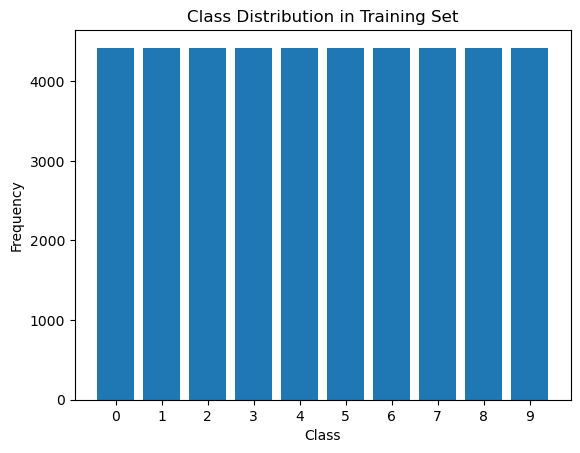

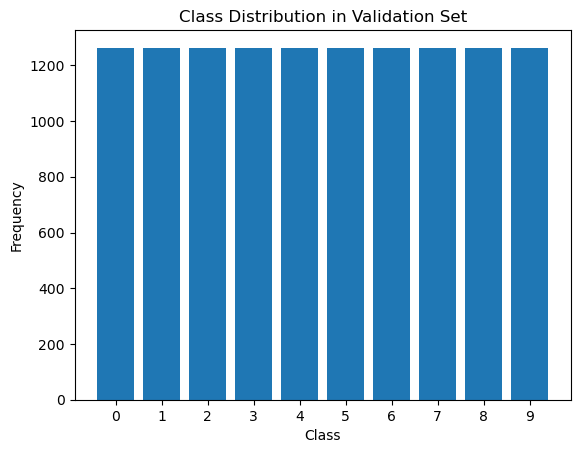

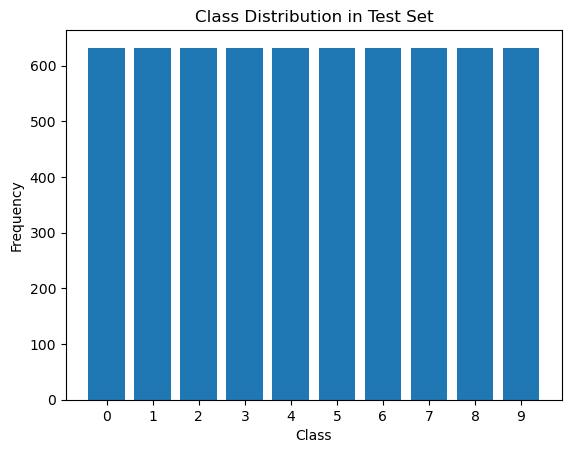

((44191, 10), (12626, 10), (6313, 10))

In [39]:
# Create a balanced dataset
x_balanced = np.empty((0, 28, 28))
y_balanced_flat = np.empty(0, dtype=int)
for i in range(10):
    indices = np.where(y_combined_flat == i)[0]
    balanced_indices = np.random.choice(indices, min_class_size, replace=False)
    x_balanced = np.vstack((x_balanced, x_combined[balanced_indices]))
    y_balanced_flat = np.concatenate((y_balanced_flat, y_combined_flat[balanced_indices]))

# Convert labels back to categorical
y_balanced = to_categorical(y_balanced_flat, 10)

# Split the balanced dataset into training (70%), validation (20%), and test (10%)
x_temp, x_test, y_temp, y_test = train_test_split(x_balanced, y_balanced, test_size=0.1, stratify=y_balanced_flat)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=(2/9), stratify=y_temp)

# Normalise the images to [0, 1]
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape the images to add a dimension for the channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Function to plot class distribution
def plot_class_distribution(labels, dataset_name):
    # Count the number of each class
    class_counts = np.sum(labels, axis=0)
    # Plot
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(range(10))
    plt.show()

# Plot the class distribution for each set
plot_class_distribution(y_train, 'Training')
plot_class_distribution(y_val, 'Validation')
plot_class_distribution(y_test, 'Test')
y_train.shape, y_val.shape, y_test.shape

Train the model

In [40]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation, Resizing, RandomContrast
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
# TEST ON MNIST ONLY

# Reshape the images to add a dimension for the channel
x_train_combined = x_train.reshape(-1, 28, 28, 1)
x_val_combined = x_val.reshape(-1, 28, 28, 1)
x_test_combined = x_test.reshape(-1, 28, 28, 1)

y_train_combined = y_train
y_val_combined = y_val
y_test_combined = y_test

x_train_combined.shape, x_val_combined.shape, x_test_combined.shape

((44191, 28, 28, 1), (12626, 28, 28, 1), (6313, 28, 28, 1))

In [42]:
# Reshape the images to add a dimension for the channel
x_train_combined = x_train_combined.reshape(-1, 28, 28, 1)
x_val_combined = x_val_combined.reshape(-1, 28, 28, 1)
x_test_combined = x_test_combined.reshape(-1, 28, 28, 1)

x_train_combined.shape, x_val_combined.shape, x_test_combined.shape

((44191, 28, 28, 1), (12626, 28, 28, 1), (6313, 28, 28, 1))

50% chance of adding Gaussian noise, and just a tad each time.

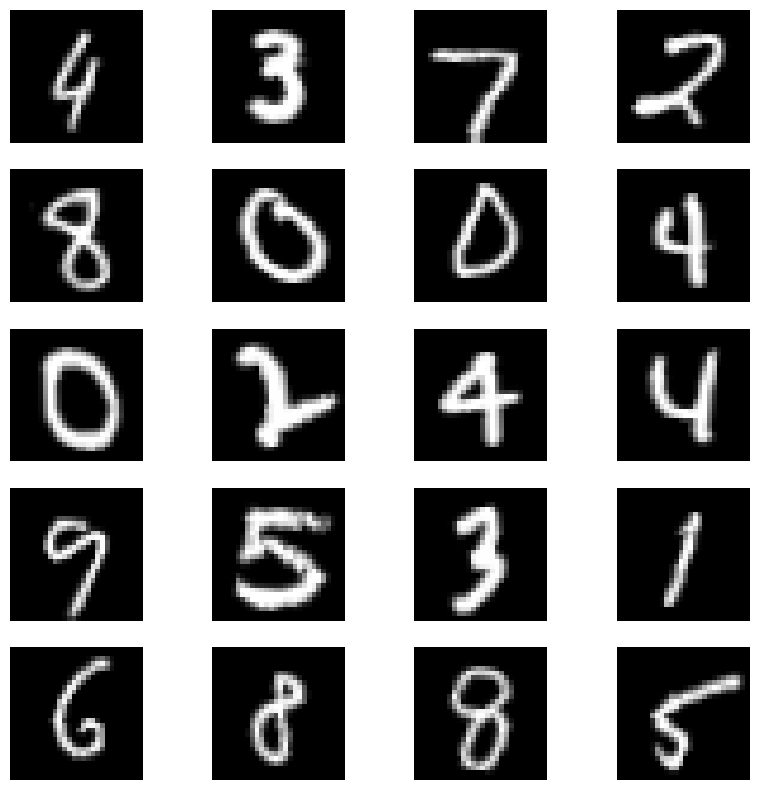

In [43]:
import random

def random_gaussian_noise(x):
    if random.random() < 0.5:  # 50% chance to add Gaussian noise
        scale = np.random.uniform(0.0001, 0.00000005)
        return x + np.random.normal(loc=0, scale=scale, size=x.shape)
    else:
        return x

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest',
    # featurewise_std_normalization=True,  # Normalize the dataset
    # preprocessing_function=random_gaussian_noise  # Add Gaussian noise
)

# Fit the data augmentation on the combined training dataset
datagen.fit(x_train_combined)

# Generate a batch of augmented images and labels
augmented_images, augmented_labels = next(datagen.flow(x_train_combined, y_train_combined, batch_size=64))

# Display the first image in the batch
plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(augmented_images[i].reshape(28,  28), cmap='gray')
    plt.axis('off')
plt.show()

In [44]:
# Define the CNN model
cnn_model_simplified = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block (Removed third block to reduce complexity)
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flattening the convolutions
    Flatten(),

    # Dense Layers (Reduced the number of neurons to lower the parameter count)
    Dense(256, activation='relu'),  # Reduced from 512 to 256
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),  # Reduced from 256 to 128
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model_simplified.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

(44191, 28, 28, 1) (44191, 10)
(12626, 28, 28, 1) (12626, 10)


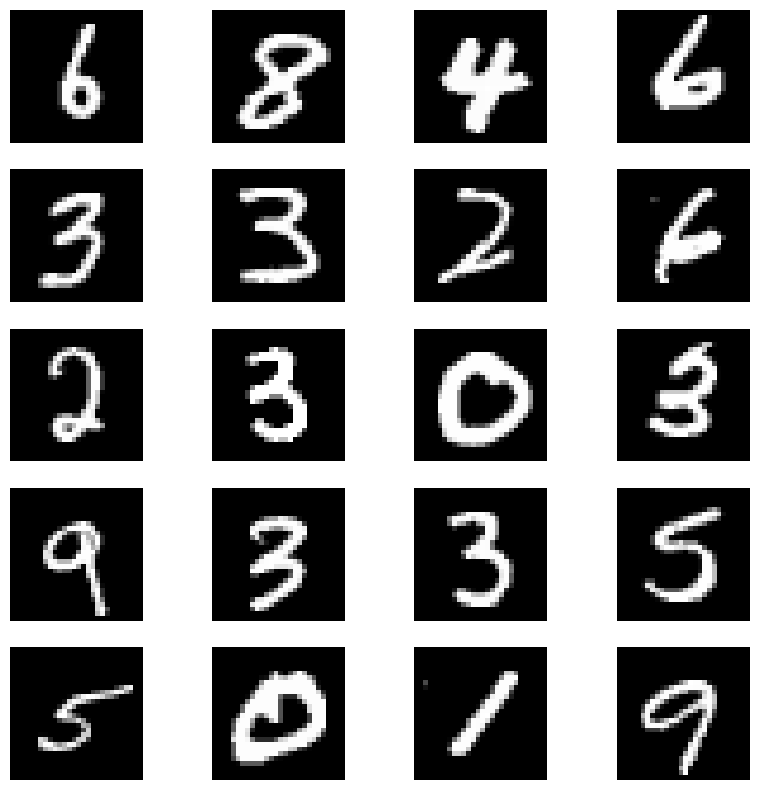

In [45]:
print(x_train_combined.shape, y_train_combined.shape)
print(x_val_combined.shape, y_val_combined.shape)

plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(x_val_combined[i].reshape(28,  28), cmap='gray')
    plt.axis('off')

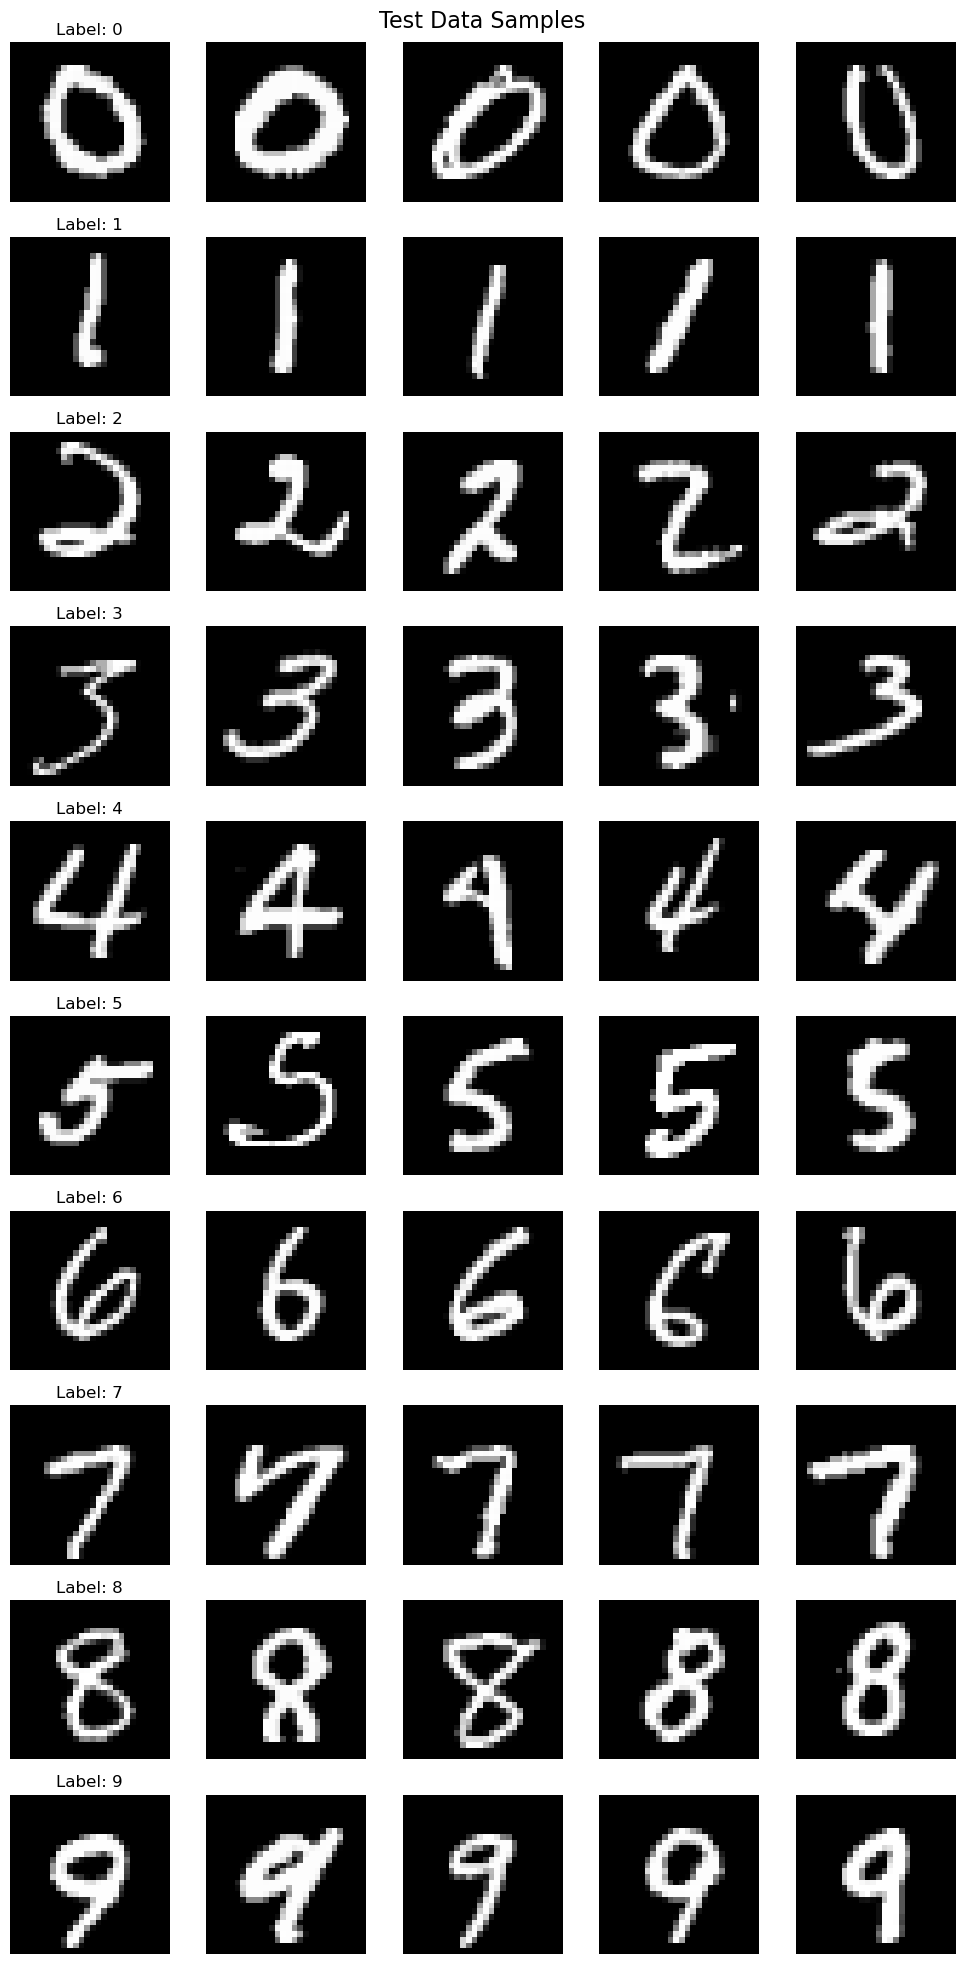

In [11]:
# Check the training and validation data are accurate

def plot_images_with_labels(images, labels, num_classes=10, title="Data", samples_per_class=5):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(2*samples_per_class, 2*num_classes))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    
    for i in range(num_classes):
        # Find images of a specific class
        class_images = images[labels == i][:samples_per_class]
        
        for j, img in enumerate(class_images):
            idx = i * samples_per_class + j
            axes[idx].imshow(img.reshape(28, 28), cmap='gray')
            axes[idx].axis('off')
            if j == 0:
                axes[idx].set_title(f'Label: {i}')
    plt.tight_layout()
    plt.show()

# Assuming you have y_train_combined and y_test_combined as one-hot encoded labels
y_train_combined_categorical = np.argmax(y_train_combined, axis=1)
y_val_combined_categorical = np.argmax(y_val_combined, axis=1)
y_test_combined_categorical = np.argmax(y_test_combined, axis=1)

# Plot training data samples
# plot_images_with_labels(x_train_combined, y_train_combined_categorical, title="Training Data Samples")
# print('y')
# plot_images_with_labels(x_val_combined, y_val_combined_categorical, title="Validation Data Samples")
plot_images_with_labels(x_test_combined, y_test_combined_categorical, title="Test Data Samples")

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming x_train_combined already normalized but let's ensure its statistics are used for validation
mean = np.mean(x_train_combined)
std = np.std(x_train_combined)

# Normalize validation data using training data's statistics
x_val_combined = (x_val_combined - mean) / std

x_val_combined.shape

# Create a generator for validation data
validation_datagen = ImageDataGenerator(featurewise_std_normalization=True)

# Fit the generator to your training data to compute feature-wise normalization
validation_datagen.fit(x_train_combined)  # Use training data to compute mean and std

/Users/oscarmoxon/anaconda3/envs/NN/lib/python3.11/site-packages/keras/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Fit

In [13]:
history = cnn_model_simplified.fit(
    datagen.flow(x_train_combined, y_train_combined, batch_size=64), 
    epochs=10, 
    validation_data=(x_val_combined, y_val_combined)  # Ensure this data is correctly preprocessed
)

Epoch 1/10


2024-02-17 20:58:43.714462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-17 20:58:43.720072: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


691/691 [==============================] - 12s 16ms/step - loss: 0.4467 - accuracy: 0.8614 - val_loss: 549.1151 - val_accuracy: 0.6035
Epoch 2/10
284/691 [===========>..................] - ETA: 6s - loss: 0.1894 - accuracy: 0.9428

KeyboardInterrupt: 

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
val_predictions = cnn_model_simplified.predict(x_val_combined)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val_combined, axis=1)

# Confusion Matrix
print(confusion_matrix(val_true_classes, val_pred_classes))

# Classification Report
print(classification_report(val_true_classes, val_pred_classes))

395/395 [==============================] - 1s 2ms/step
[[  37    0    0    4 1023    1    0    0  197    0]
 [ 164    0    0    0  946    0    0    0  153    0]
 [  10    0    0    7  976    0    0    0  270    0]
 [   3    0    0    0 1145    1    0    0  113    0]
 [  13    0    0    9  974    2    0    0  264    0]
 [ 150    0    0    0  993    3    0    0  117    0]
 [   3    0    0   14  979    1    0    0  265    0]
 [  23    0    0    0  750   15    0    0  475    0]
 [  25    0    0    0 1125    0    0    0  113    0]
 [   2    0    0    1 1155    0    0    0  105    0]]
              precision    recall  f1-score   support

           0       0.09      0.03      0.04      1262
           1       0.00      0.00      0.00      1263
           2       0.00      0.00      0.00      1263
           3       0.00      0.00      0.00      1262
           4       0.10      0.77      0.17      1262
           5       0.13      0.00      0.00      1263
           6       0.00      0.00  

/Users/oscarmoxon/anaconda3/envs/NN/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/oscarmoxon/anaconda3/envs/NN/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/oscarmoxon/anaconda3/envs/NN/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

NameError: name 'history' is not defined

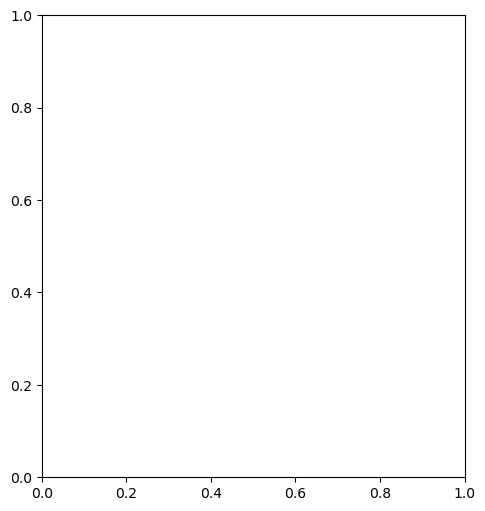

In [48]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [63]:
net = cnn_model_simplified

#determine what type of network this is
conf=net.layers[0].get_config()
inshape=conf['batch_input_shape']
if inshape[1]==28:
    netType='CNN'
else:
    netType='MLP'

netType

'CNN'

In [64]:
#test with MNIST data
from tensorflow.keras.datasets import mnist
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()
x_test = x_test.astype('float32')
x_test /= 255
if netType in ['MLP']:
    x_test = x_test.reshape(10000, 784)
else:
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

outputs=net.predict(x_test)
labels_predicted=np.argmax(outputs, axis=1)
correct_classified=sum(labels_predicted==labels_test)
print('Percentage correctly classified MNIST=', 100 * correct_classified / labels_test.size)

313/313 [==============================] - 1s 2ms/step
Percentage correctly classified MNIST= 9.25


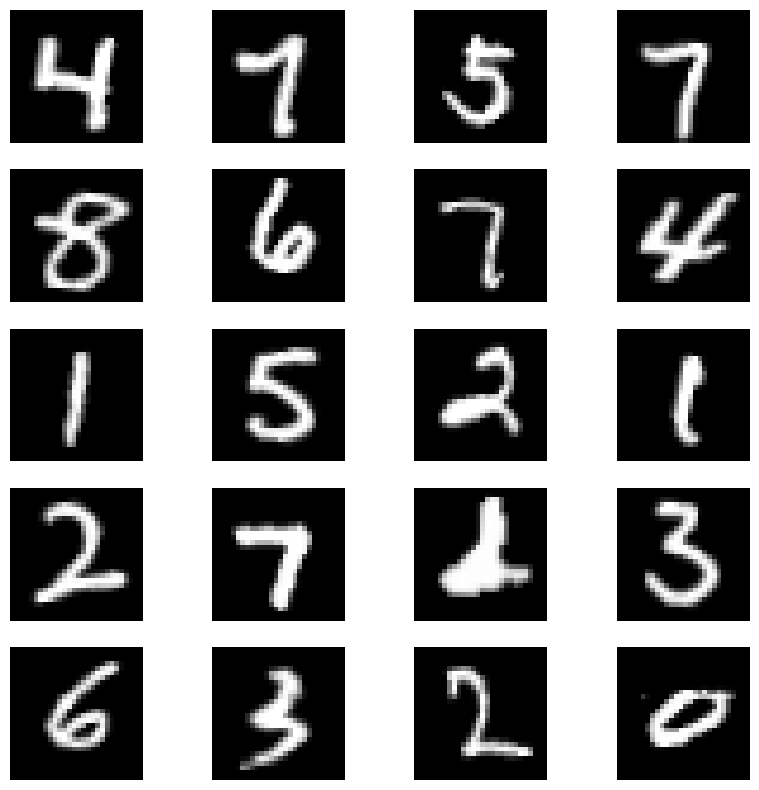

In [ ]:
import random

def random_gaussian_noise(x):
    if random.random() < 0.5:  # 50% chance to add Gaussian noise
        scale = np.random.uniform(0.00000005, 0)
        return x + np.random.normal(loc=0, scale=scale, size=x.shape)
    else:
        return x

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest',
    # featurewise_std_normalization=True,  # Normalize the dataset
    # preprocessing_function=random_gaussian_noise  # Add Gaussian noise
)

# Fit the data augmentation on the combined training dataset
datagen.fit(x_train_combined)

# Generate a batch of augmented images and labels
augmented_images, augmented_labels = next(datagen.flow(x_train_combined, y_train_combined, batch_size=64))

# Display the first image in the batch
plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(augmented_images[i].reshape(28,  28), cmap='gray')
    plt.axis('off')
plt.show()

In [67]:
# Define the CNN model
cnn_model_gauss = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block (Removed third block to reduce complexity)
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flattening the convolutions
    Flatten(),

    # Dense Layers (Reduced the number of neurons to lower the parameter count)
    Dense(256, activation='relu'),  # Reduced from 512 to 256
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),  # Reduced from 256 to 128
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model_gauss.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
history_gauss = cnn_model_gauss.fit(
    datagen.flow(x_train_combined, y_train_combined, batch_size=64), 
    epochs=10, 
    validation_data=(x_val_combined, y_val_combined)  # Ensure this data is correctly preprocessed
)

Epoch 1/10


2024-02-18 14:21:27.637610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


878/878 [==============================] - 14s 15ms/step - loss: 0.4274 - accuracy: 0.8677 - val_loss: 324.5169 - val_accuracy: 0.7967
Epoch 2/10
878/878 [==============================] - 14s 16ms/step - loss: 0.1612 - accuracy: 0.9516 - val_loss: 372.7090 - val_accuracy: 0.7842
Epoch 3/10
878/878 [==============================] - 14s 16ms/step - loss: 0.1257 - accuracy: 0.9623 - val_loss: 292.3251 - val_accuracy: 0.8153
Epoch 4/10
878/878 [==============================] - 14s 16ms/step - loss: 0.1067 - accuracy: 0.9689 - val_loss: 405.5606 - val_accuracy: 0.7662
Epoch 5/10
878/878 [==============================] - 15s 17ms/step - loss: 0.0965 - accuracy: 0.9713 - val_loss: 239.4326 - val_accuracy: 0.8156
Epoch 6/10
878/878 [==============================] - 14s 16ms/step - loss: 0.0870 - accuracy: 0.9745 - val_loss: 247.9661 - val_accuracy: 0.8166
Epoch 7/10
878/878 [==============================] - 14s 16ms/step - loss: 0.0825 - accuracy: 0.9762 - val_loss: 217.9407 - val_accura

In [70]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
val_predictions = cnn_model_gauss.predict(x_val_combined)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val_combined, axis=1)

# Confusion Matrix
print(confusion_matrix(val_true_classes, val_pred_classes))

# Classification Report
print(classification_report(val_true_classes, val_pred_classes))

395/395 [==============================] - 1s 2ms/step
[[ 254    0  635    0    0    1    3    0  335   34]
 [   0  129  223    2   77    0    0  198  631    3]
 [   0    0 1209    0    1    0    0    0   53    0]
 [   0    0   13 1061    0    2    0    1  183    2]
 [   0    0   12    0 1036    0    0    0  209    5]
 [   0    0    0    6    0  953    0    0  297    7]
 [   0    0   26    0    0    0  533    0  703    0]
 [   0    0   16    6   18    1    0  795   85  342]
 [   0    0    1    0    0    0    0    0 1262    0]
 [   0    0    7    2    5    1    0    0  151 1097]]
              precision    recall  f1-score   support

           0       1.00      0.20      0.34      1262
           1       1.00      0.10      0.19      1263
           2       0.56      0.96      0.71      1263
           3       0.99      0.84      0.91      1262
           4       0.91      0.82      0.86      1262
           5       0.99      0.75      0.86      1263
           6       0.99      0.42  

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
test_predictions = cnn_model_gauss.predict(x_test_combined)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(y_test_combined, axis=1)

# Confusion Matrix
print(confusion_matrix(test_true_classes, test_pred_classes))

# Classification Report
print(classification_report(test_true_classes, test_pred_classes))

198/198 [==============================] - 1s 3ms/step
[[625   1   0   0   0   1   2   0   1   1]
 [  0 627   0   0   0   0   0   4   0   0]
 [  0   1 624   2   0   0   0   4   0   0]
 [  0   0   0 623   0   3   0   2   2   1]
 [  0   2   0   0 628   0   1   0   0   0]
 [  1   0   1   2   0 624   2   1   0   1]
 [  1   1   0   0   1   2 627   0   0   0]
 [  0   2   1   0   2   0   0 627   0   0]
 [  2   3   1   2   0   3   0   3 614   3]
 [  3   1   0   0   6   2   0   6   1 612]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       631
           1       0.98      0.99      0.99       631
           2       1.00      0.99      0.99       631
           3       0.99      0.99      0.99       631
           4       0.99      1.00      0.99       631
           5       0.98      0.99      0.99       632
           6       0.99      0.99      0.99       632
           7       0.97      0.99      0.98       632
           8       0.99    

In [73]:
net = cnn_model_gauss

#determine what type of network this is
conf=net.layers[0].get_config()
inshape=conf['batch_input_shape']
if inshape[1]==28:
    netType='CNN'
else:
    netType='MLP'

#test with MNIST data
from tensorflow.keras.datasets import mnist
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()
x_test = x_test.astype('float32')
x_test /= 255
if netType in ['MLP']:
    x_test = x_test.reshape(10000, 784)
else:
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

outputs=net.predict(x_test)
labels_predicted=np.argmax(outputs, axis=1)
correct_classified=sum(labels_predicted==labels_test)
print('Percentage correctly classified MNIST=', 100 * correct_classified / labels_test.size)

313/313 [==============================] - 1s 2ms/step
Percentage correctly classified MNIST= 31.74


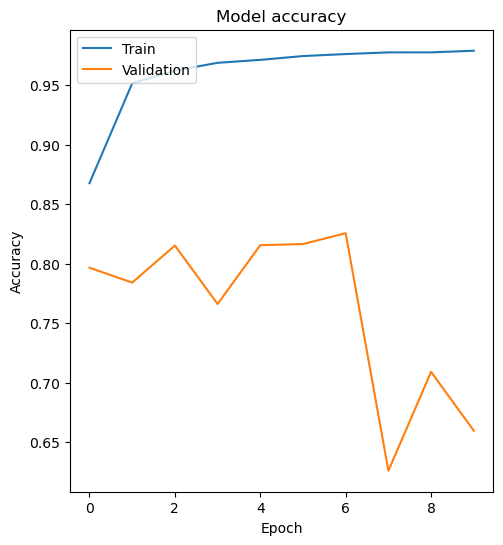

In [72]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gauss.history['accuracy'])
plt.plot(history_gauss.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# EMNIST

In [49]:
from emnist import extract_training_samples, extract_test_samples

# Load EMNIST data
emnist_images, emnist_labels = extract_training_samples('digits')
emnist_test_images, emnist_test_labels = extract_test_samples('digits')

# Normalize the images to [0, 1]
emnist_images = emnist_images.astype('float32') / 255
emnist_test_images = emnist_test_images.astype('float32') / 255

# Convert labels to one-hot encoding`
# emnist_labels = to_categorical(emnist_labels, 10)
# emnist_test_labels = to_categorical(emnist_test_labels, 10)

# Reshape the images to add a dimension for the channel
emnist_images = emnist_images.reshape(emnist_images.shape[0], 28, 28, 1)
emnist_test_images = emnist_test_images.reshape(emnist_test_images.shape[0], 28, 28, 1)

emnist_images.shape, emnist_labels.shape

((240000, 28, 28, 1), (240000,))

In [50]:
# Assuming emnist_test_labels is already loaded and is a flat array of labels (not one-hot encoded)
unique_classes = np.unique(emnist_test_labels)
sample_per_class = 2400
balanced_indices = []
for cls in unique_classes:
    cls_indices = np.where(emnist_test_labels == cls)[0]
    cls_sample_indices = np.random.choice(cls_indices, sample_per_class, replace=False)
    balanced_indices.extend(cls_sample_indices)

# Now, extract the images and labels using the indices
emnist_x_balanced = emnist_test_images[balanced_indices]
emnist_y_balanced = emnist_test_labels[balanced_indices]
# emnist_x_balanced.shape, emnist_y_balanced.shape

# Normalize, reshape, and convert labels to one-hot encoding as necessary
emnist_x_balanced = emnist_x_balanced.astype('float32') / 255
emnist_x_balanced = emnist_x_balanced.reshape(-1, 28, 28, 1)
# emnist_y_balanced_one_hot = to_categorical(emnist_y_balanced, 10)

# Split the balanced dataset into training (70%), validation (20%), and test (10%)
ex_temp, ex_test, ey_temp, ey_test = train_test_split(emnist_x_balanced, emnist_y_balanced, test_size=0.1, stratify=emnist_y_balanced)
ex_train, ex_val, ey_train, ey_val = train_test_split(ex_temp, ey_temp, test_size=(4/9), stratify=ey_temp)

In [51]:
# Reshape the images to add a dimension for the channel
ex_train_combined = ex_train.reshape(-1, 28, 28, 1)
ex_val_combined = ex_val.reshape(-1, 28, 28, 1)
ex_test_combined = ex_test.reshape(-1, 28, 28, 1)

ey_train_combined = ey_train
ey_val_combined = ey_val
ey_test_combined = ey_test

ex_train_combined.shape, ex_val_combined.shape, ex_test_combined.shape

((12000, 28, 28, 1), (9600, 28, 28, 1), (2400, 28, 28, 1))

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
eval_predictions = cnn_model_gauss.predict(ex_val_combined)
eval_pred_classes = np.argmax(eval_predictions, axis=1)
eval_true_classes = ey_val_combined

# Confusion Matrix
print(confusion_matrix(eval_true_classes, eval_pred_classes))

# Classification Report
print(classification_report(eval_true_classes, eval_pred_classes))

NameError: name 'cnn_model_gauss' is not defined

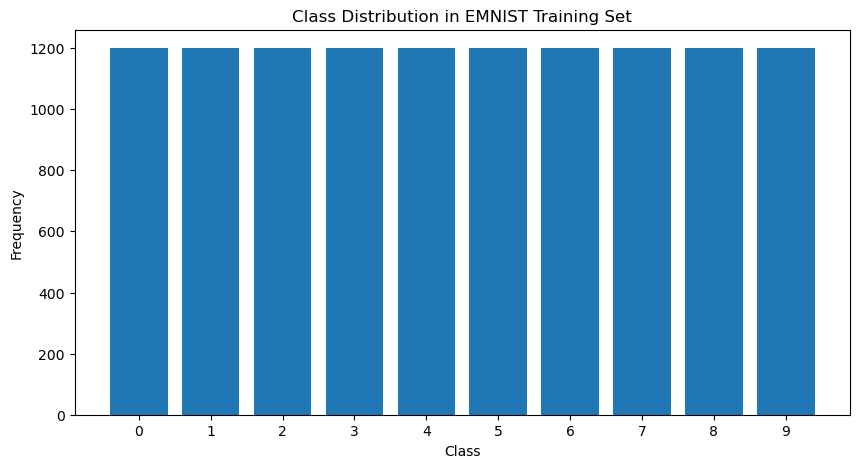

In [52]:
# Assuming ey_train is a flat array of class indices
def plot_class_distribution(labels, dataset_name="Training"):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    plt.bar(unique, counts)
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(unique)
    plt.show()

# Plot class distribution for EMNIST training set
plot_class_distribution(ey_train_combined, "EMNIST Training")

In [53]:
# Combine
y_train_combined = np.concatenate([y_train_combined, to_categorical(ey_train_combined, 10)])
x_train_combined = np.concatenate([x_train, ex_train_combined])

y_train_combined.shape, x_train_combined.shape

((56191, 10), (56191, 28, 28, 1))

In [54]:
# Define the CNN model
cnn_model_combo = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block (Removed third block to reduce complexity)
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flattening the convolutions
    Flatten(),

    # Dense Layers (Reduced the number of neurons to lower the parameter count)
    Dense(256, activation='relu'),  # Reduced from 512 to 256
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),  # Reduced from 256 to 128
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model_combo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
history_combo = cnn_model_combo.fit(
    datagen.flow(x_train_combined, y_train_combined, batch_size=64), 
    epochs=10, 
    validation_data=(x_val_combined, y_val_combined)  # Ensure this data is correctly preprocessed
)

Epoch 1/10


2024-02-17 21:11:42.475219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


878/878 [==============================] - 14s 16ms/step - loss: 0.4383 - accuracy: 0.8643 - val_loss: 605.1592 - val_accuracy: 0.7089
Epoch 2/10
878/878 [==============================] - 16s 19ms/step - loss: 0.1629 - accuracy: 0.9511 - val_loss: 323.6196 - val_accuracy: 0.7774
Epoch 3/10
878/878 [==============================] - 13s 15ms/step - loss: 0.1319 - accuracy: 0.9605 - val_loss: 330.3879 - val_accuracy: 0.7401
Epoch 4/10
878/878 [==============================] - 15s 17ms/step - loss: 0.1149 - accuracy: 0.9651 - val_loss: 561.8887 - val_accuracy: 0.6402
Epoch 5/10
878/878 [==============================] - 14s 16ms/step - loss: 0.1012 - accuracy: 0.9701 - val_loss: 215.5499 - val_accuracy: 0.7989
Epoch 6/10
878/878 [==============================] - 14s 16ms/step - loss: 0.0926 - accuracy: 0.9718 - val_loss: 289.3089 - val_accuracy: 0.7902
Epoch 7/10
878/878 [==============================] - 14s 16ms/step - loss: 0.0896 - accuracy: 0.9734 - val_loss: 231.7733 - val_accura

In [58]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
test_predictions = cnn_model_combo.predict(x_test_combined)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(y_test_combined, axis=1)

# Confusion Matrix
print(confusion_matrix(test_true_classes, test_pred_classes))

# Classification Report
print(classification_report(test_true_classes, test_pred_classes))

198/198 [==============================] - 0s 2ms/step
[[631   0   0   0   0   0   0   1   0   0]
 [  0 628   1   0   0   0   1   1   0   0]
 [  1   0 626   0   0   0   0   4   0   0]
 [  0   1   2 622   0   0   0   2   2   2]
 [  0   1   0   0 628   0   1   0   0   2]
 [  0   0   0   1   0 622   7   0   0   1]
 [  2   0   0   0   0   0 630   0   0   0]
 [  1   1   3   0   2   0   0 624   0   0]
 [  3   0   3   0   1   0   5   0 615   4]
 [  0   0   0   0   7   0   0   2   1 621]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       632
           1       1.00      1.00      1.00       631
           2       0.99      0.99      0.99       631
           3       1.00      0.99      0.99       631
           4       0.98      0.99      0.99       632
           5       1.00      0.99      0.99       631
           6       0.98      1.00      0.99       632
           7       0.98      0.99      0.99       631
           8       1.00    

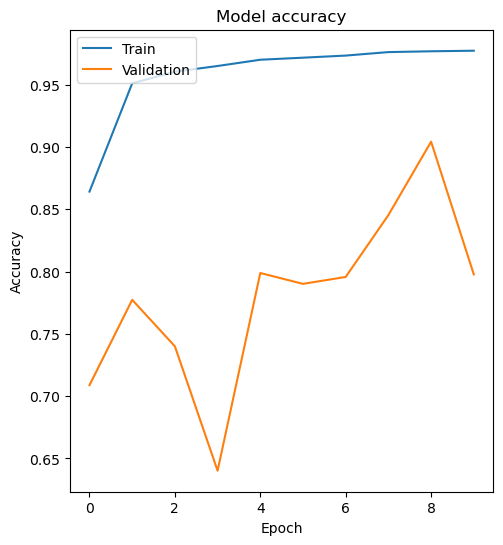

In [62]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_combo.history['accuracy'])
plt.plot(history_combo.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [69]:
net = history_combo

#determine what type of network this is
conf=net.layers[0].get_config()
inshape=conf['batch_input_shape']
if inshape[1]==28:
    netType='CNN'
else:
    netType='MLP'

netType

AttributeError: 'History' object has no attribute 'layers'

In [ ]:
#test with MNIST data
from tensorflow.keras.datasets import mnist
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()
x_test = x_test.astype('float32')
x_test /= 255
if netType in ['MLP']:
    x_test = x_test.reshape(10000, 784)
else:
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

outputs=net.predict(x_test)
labels_predicted=np.argmax(outputs, axis=1)
correct_classified=sum(labels_predicted==labels_test)
print('Percentage correctly classified MNIST=', 100 * correct_classified / labels_test.size)

In [60]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
eval_predictions = cnn_model_combo.predict(ex_val_combined)
eval_pred_classes = np.argmax(eval_predictions, axis=1)
eval_true_classes = ey_val_combined

# Confusion Matrix
print(confusion_matrix(eval_true_classes, eval_pred_classes))

# Classification Report
print(classification_report(eval_true_classes, eval_pred_classes))

300/300 [==============================] - 1s 2ms/step
[[955   0   1   0   0   0   2   0   0   2]
 [  0 958   1   0   0   0   0   1   0   0]
 [  0   0 955   3   0   0   0   2   0   0]
 [  0   1   1 955   0   1   0   1   1   0]
 [  1   1   0   0 954   0   4   0   0   0]
 [  3   1   0   4   0 948   4   0   0   0]
 [  3   2   0   0   0   0 955   0   0   0]
 [  0   2   0   0   2   0   0 956   0   0]
 [  2   4   1   3   0   0   3   0 940   7]
 [  0   1   0   2   4   0   0   6   0 947]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       960
           1       0.99      1.00      0.99       960
           2       1.00      0.99      1.00       960
           3       0.99      0.99      0.99       960
           4       0.99      0.99      0.99       960
           5       1.00      0.99      0.99       960
           6       0.99      0.99      0.99       960
           7       0.99      1.00      0.99       960
           8       1.00    

In [61]:
cnn_model_combo.save('cnn_model_combo.h5')

In [ ]:
history_combo = cnn_model_combo.fit(
    datagen.flow(x_train_combined, y_train_combined, batch_size=64), 
    epochs=10, 
    validation_data=(x_val_combined, y_val_combined)  # Ensure this data is correctly preprocessed
)